In [1]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier 

In [2]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])

In [3]:
df_recent_stats = pd.read_csv("./recent_stats.csv", index_col=0)

In [4]:
df_recent_stats.fillna({'HomeShots':10, 'HomeShotsOnTarget':3, 'HomeShotsFromPK':0.2, 'HomePasses':400,
                        'HomeCrosses':16, 'HomeDirectFK':10, 'HomeIndirectFK':2, 'HomeCK':4,
                        'HomeThrowin':20, 'HomeDribbling':10, 'HomeTackles':18, 'HomeClearances':23,
                        'HomeIntercepts':2, 'HomeOffsides':1.5, 'HomeYellowCards':1, 'HomeRedCards':0,
                        'Home30mLineEntries':33, 'HomePenaltyAreaEntries':9, 'HomeAttacks':117,
                        'HomeChanceBuildingRate':10, 'HomePossession':44,
                        'AwayShots':10, 'AwayShotsOnTarget':3, 'AwayShotsFromPK':0.2, 'AwayPasses':400,
                        'AwayCrosses':16, 'AwayDirectFK':10, 'AwayIndirectFK':2, 'AwayCK':4,
                        'AwayThrowin':20, 'AwayDribbling':10, 'AwayTackles':18, 'AwayClearances':23,
                        'AwayIntercepts':2, 'AwayOffsides':1.5, 'AwayYellowCards':1, 'AwayRedCards':0,
                        'Away30mLineEntries':33, 'AwayPenaltyAreaEntries':9, 'AwayAttacks':117,
                        'AwayChanceBuildingRate':10, 'AwayPossession':44}, inplace=True)

↑は欠損値処理で20年のベガルタ(17位)とベルマーレ(18位)の真ん中あたりの数値を適当に入れたので,もっとロジック的に欠損値を割り出せば多少は的中率上がるかもしれない｡ ただ同じ下位チームでも戦術によってstatsが全然変わってくるので,論理的に欠損値を処理するのが難しい｡

ちなみに欠損値が出ているところは前年のJ1のstatsがないということなので,前年はJ2だったクラブということ｡(≒下位のクラブに相当する)また12年からstatsを取得できたため,12年の序盤までは例外的に欠損値

In [5]:
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)

In [6]:
df_allmatch

Year  Sec       Date                  Home                 Away  \
ID                                                                          
6010524   2006    1 2006-03-05   yokohama-fa-marinos          kyoto-sanga   
6010820   2006    1 2006-03-05  nagoya-grampus-eight         cerezo-osaka   
6010903   2006    1 2006-03-04           gamba-osaka   urawa-red-diamonds   
6011001   2006    1 2006-03-05   sanfrecce-hiroshima      kashima-antlers   
6011323   2006    1 2006-03-05          jubilo-iwata       avispa-fukuoka   
...        ...  ...        ...                   ...                  ...   
20341121  2020   34 2020-12-19        kashiwa-reysol    kawasaki-frontale   
20342218  2020   34 2020-12-19              fc-tokyo          vissel-kobe   
20343331  2020   34 2020-12-19            sagan-tosu         oita-trinita   
20343405  2020   34 2020-12-19           yokohama-fc  yokohama-fa-marinos   
20345412  2020   34 2020-12-19        vegalta-sendai      shonan-bellmare   

          HomeID  AwayID  HomeGF  AwayGF  W/L Stadium  Attendances  HomeRate  \
ID                                                                             
6010524        5      24       4       1    1     日産ス        23607      1500   
6010820        8      20       3       2    1     瑞穂陸        17199      1500   
6010903        9       3       1       1    0      万博        20916      1500   
6011001       10       1       3       4    2     広島ビ        17564      1500   
6011323       13      23       1       1    0      静岡        28564      1500   
...          ...     ...     ...     ...  ...     ...          ...       ...   
20341121      11      21       2       3    2    三協Ｆ柏         5137      1519   
20342218      22      18       1       0    1     味スタ        14373      1540   
20343331      33      31       2       2    0     駅スタ         8966      1453   
20343405      34       5       3       1    1    ニッパツ         6766      1343   
20345412      54      12       0       0    0    ユアスタ         7356      1418   

          AwayRate  HomeRD  AwayRD  
ID                                  
6010524       1500       0       0  
6010820       1500       0       0  
6010903       1500       0       0  
6011001       1500       0       0  
6011323       1500       0       0  
...            ...     ...     ...  
20341121      1682       6     -13  
20342218      1453       8       0  
20343331      1458      17       7  
20343405      1543      -8       0  
20345412      1395      17     -12  

[4590 rows x 16 columns]

In [7]:
df = pd.concat([df_allmatch, df_recent_stats], axis=1)

In [8]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)

In [9]:
df

Year  Sec                  Home                 Away  HomeID  \
Date                                                                       
2006-03-04  2006    1           gamba-osaka   urawa-red-diamonds       9   
2006-03-05  2006    1   yokohama-fa-marinos          kyoto-sanga       5   
2006-03-05  2006    1  nagoya-grampus-eight         cerezo-osaka       8   
2006-03-05  2006    1   sanfrecce-hiroshima      kashima-antlers      10   
2006-03-05  2006    1          jubilo-iwata       avispa-fukuoka      13   
...          ...  ...                   ...                  ...     ...   
2020-12-19  2020   34  nagoya-grampus-eight  sanfrecce-hiroshima       8   
2020-12-19  2020   34    urawa-red-diamonds    consadole-sapporo       3   
2020-12-19  2020   34       kashima-antlers         cerezo-osaka       1   
2020-12-19  2020   34           gamba-osaka      shimizu-s-pulse       9   
2020-12-19  2020   34        vegalta-sendai      shonan-bellmare      54   

            AwayID  HomeGF  AwayGF  W/L Stadium  ...  AwayClearances  \
Date                                             ...                   
2006-03-04       3       1       1    0      万博  ...             NaN   
2006-03-05      24       4       1    1     日産ス  ...             NaN   
2006-03-05      20       3       2    1     瑞穂陸  ...             NaN   
2006-03-05       1       3       4    2     広島ビ  ...             NaN   
2006-03-05      23       1       1    0      静岡  ...             NaN   
...            ...     ...     ...  ...     ...  ...             ...   
2020-12-19      10       1       0    1     豊田ス  ...            21.8   
2020-12-19      14       0       2    2      埼玉  ...            18.8   
2020-12-19      20       1       1    0     カシマ  ...            24.2   
2020-12-19       7       0       2    2    パナスタ  ...            25.6   
2020-12-19      12       0       0    0    ユアスタ  ...            20.8   

            AwayIntercepts  AwayOffsides  AwayYellowCards  AwayRedCards  \
Date                                                                      
2006-03-04             NaN           NaN              NaN           NaN   
2006-03-05             NaN           NaN              NaN           NaN   
2006-03-05             NaN           NaN              NaN           NaN   
2006-03-05             NaN           NaN              NaN           NaN   
2006-03-05             NaN           NaN              NaN           NaN   
...                    ...           ...              ...           ...   
2020-12-19             1.8           3.0              1.0           0.2   
2020-12-19             1.6           1.8              1.0           0.0   
2020-12-19             1.8           1.8              0.4           0.0   
2020-12-19             2.4           1.6              1.0           0.0   
2020-12-19             0.8           1.6              0.6           0.0   

            Away30mLineEntries  AwayPenaltyAreaEntries  AwayAttacks  \
Date                                                                  
2006-03-04                 NaN                     NaN          NaN   
2006-03-05                 NaN                     NaN          NaN   
2006-03-05                 NaN                     NaN          NaN   
2006-03-05                 NaN                     NaN          NaN   
2006-03-05                 NaN                     NaN          NaN   
...                        ...                     ...          ...   
2020-12-19                50.4                    14.2        127.2   
2020-12-19                46.4                    13.8        123.8   
2020-12-19                34.4                    13.2        113.4   
2020-12-19                34.2                    11.8        115.4   
2020-12-19                35.4                     9.6        129.0   

            AwayChanceBuildingRate  AwayPossession  
Date                                                
2006-03-04                     NaN             NaN  
2006-03-05                 

---

### 訓練データ: recent_stats

2015 的中率:0.435, 対数損失:1.058, 較正値:1.048
2016 的中率:0.490, 対数損失:1.031, 較正値:0.959
2017 的中率:0.458, 対数損失:1.060, 較正値:1.013
2018 的中率:0.425, 対数損失:1.059, 較正値:1.068
2019 的中率:0.435, 対数損失:1.072, 較正値:1.063
2020 的中率:0.458, 対数損失:1.055, 較正値:0.978
的中率(Accuracy) : 0.450
対数損失(Log loss) : 1.056
較正値(Calibration ) : 1.022


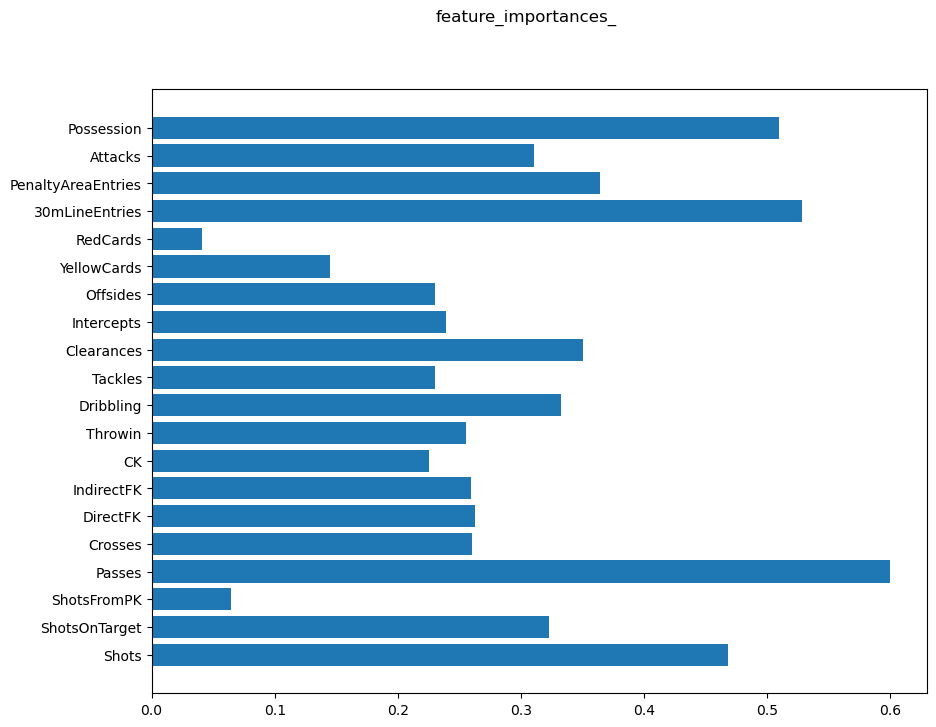

In [16]:
loglosses = []
accuracies = []
calibrations = []
feature_imp_sum = np.zeros(40)


df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)

df_recent_stats = pd.read_csv("./recent_stats.csv", index_col=0)
df_recent_stats.fillna({'HomeShots':10, 'HomeShotsOnTarget':3, 'HomeShotsFromPK':0.2, 'HomePasses':400,
                        'HomeCrosses':16, 'HomeDirectFK':10, 'HomeIndirectFK':2, 'HomeCK':4,
                        'HomeThrowin':20, 'HomeDribbling':10, 'HomeTackles':18, 'HomeClearances':23,
                        'HomeIntercepts':2, 'HomeOffsides':1.5, 'HomeYellowCards':1, 'HomeRedCards':0,
                        'Home30mLineEntries':33, 'HomePenaltyAreaEntries':9, 'HomeAttacks':117,
                        'HomeChanceBuildingRate':10, 'HomePossession':44,
                        'AwayShots':10, 'AwayShotsOnTarget':3, 'AwayShotsFromPK':0.2, 'AwayPasses':400,
                        'AwayCrosses':16, 'AwayDirectFK':10, 'AwayIndirectFK':2, 'AwayCK':4,
                        'AwayThrowin':20, 'AwayDribbling':10, 'AwayTackles':18, 'AwayClearances':23,
                        'AwayIntercepts':2, 'AwayOffsides':1.5, 'AwayYellowCards':1, 'AwayRedCards':0,
                        'Away30mLineEntries':33, 'AwayPenaltyAreaEntries':9, 'AwayAttacks':117,
                        'AwayChanceBuildingRate':10, 'AwayPossession':44}, inplace=True)
df_recent_stats.sort_index(inplace=True)

df = pd.concat([df_allmatch[["W/L","Date"]],df_recent_stats], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)

for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[[ 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession', 'AwayShots',
             'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[[ 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession', 'AwayShots',
             'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    feature_imp_sum = feature_imp_sum + rf.feature_importances_

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")



### feature_importances_の可視化
feature_imp_sum = feature_imp_sum[:20]+feature_imp_sum[20:]
left = range(20)
height=feature_imp_sum

label = ['Shots', 'ShotsOnTarget', 'ShotsFromPK','Passes', 'Crosses', 'DirectFK', 'IndirectFK', 'CK','Throwin', 'Dribbling', 'Tackles', 'Clearances',
       'Intercepts', 'Offsides', 'YellowCards', 'RedCards','30mLineEntries', 'PenaltyAreaEntries', 'Attacks', 'Possession']

plt.figure(figsize=(10, 8), dpi=100)
plt.barh(left, height,tick_label=label, align="center")
plt.suptitle("feature_importances_")
plt.show()

### 考察

recent_statsだけでeloratingとほぼ同等の精度が出た｡ 

また､パス数､30m進入回数､ボール支配率あたりが重要度の高い特徴量になっている｡
これをレーティングと合わせて学習させたらどうなるか

###  訓練データ: recent_stats, Rate, RD(1月前との差分) 

2015 的中率:0.461, 対数損失:1.053, 較正値:0.999
2016 的中率:0.497, 対数損失:1.014, 較正値:0.963
2017 的中率:0.480, 対数損失:1.046, 較正値:0.989
2018 的中率:0.402, 対数損失:1.067, 較正値:1.144
2019 的中率:0.431, 対数損失:1.076, 較正値:1.069
2020 的中率:0.500, 対数損失:1.048, 較正値:0.891
的中率(Accuracy) : 0.462
対数損失(Log loss) : 1.051
較正値(Calibration ) : 1.009


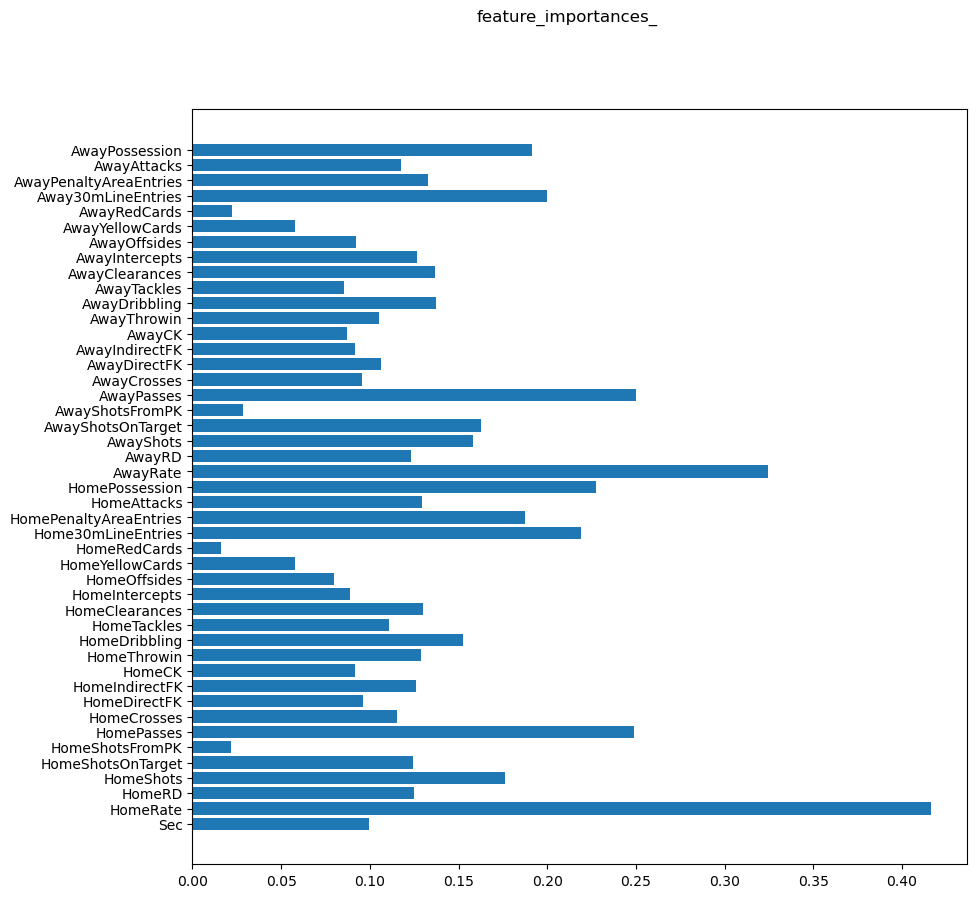

In [17]:
loglosses = []
accuracies = []
calibrations = []
feature_imp_sum = np.zeros(45)

df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)

df_recent_stats = pd.read_csv("./recent_stats.csv", index_col=0)
df_recent_stats.fillna({'HomeShots':10, 'HomeShotsOnTarget':3, 'HomeShotsFromPK':0.2, 'HomePasses':400,
                        'HomeCrosses':16, 'HomeDirectFK':10, 'HomeIndirectFK':2, 'HomeCK':4,
                        'HomeThrowin':20, 'HomeDribbling':10, 'HomeTackles':18, 'HomeClearances':23,
                        'HomeIntercepts':2, 'HomeOffsides':1.5, 'HomeYellowCards':1, 'HomeRedCards':0,
                        'Home30mLineEntries':33, 'HomePenaltyAreaEntries':9, 'HomeAttacks':117,
                        'HomeChanceBuildingRate':10, 'HomePossession':44,
                        'AwayShots':10, 'AwayShotsOnTarget':3, 'AwayShotsFromPK':0.2, 'AwayPasses':400,
                        'AwayCrosses':16, 'AwayDirectFK':10, 'AwayIndirectFK':2, 'AwayCK':4,
                        'AwayThrowin':20, 'AwayDribbling':10, 'AwayTackles':18, 'AwayClearances':23,
                        'AwayIntercepts':2, 'AwayOffsides':1.5, 'AwayYellowCards':1, 'AwayRedCards':0,
                        'Away30mLineEntries':33, 'AwayPenaltyAreaEntries':9, 'AwayAttacks':117,
                        'AwayChanceBuildingRate':10, 'AwayPossession':44}, inplace=True)
df_recent_stats.sort_index(inplace=True)

df = pd.concat([df_allmatch ,df_recent_stats], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)

for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[['Sec', 'HomeRate','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession',
             'AwayRate','AwayRD', 'AwayShots','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[['Sec', 'HomeRate','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession',
             'AwayRate','AwayRD', 'AwayShots','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    feature_imp_sum = feature_imp_sum + rf.feature_importances_

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")


### feature_importances_の可視化
left = range(len(feature_imp_sum))
height=feature_imp_sum

label = ['Sec', 'HomeRate','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession',
             'AwayRate','AwayRD', 'AwayShots','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']

plt.figure(figsize=(10, 10), dpi=100)
plt.barh(left, height,tick_label=label, align="center")
plt.suptitle("feature_importances_")
plt.show()

### 検証

レーティングも加えて検証したところ､レーティングは重要度としては高い｡的中率は微増したが､較正値の誤差は大きくなった｡
単純に過去の数字持ってきて､食べさせて､だけでは精度が上がらない感じはする

### 訓練データ: recent_stats, RD, Rateの差分

In [18]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)
df_allmatch.insert(14, "RatingDiff", df_allmatch["HomeRate"]-df_allmatch["AwayRate"])
df_allmatch

Year  Sec       Date                  Home                 Away  \
ID                                                                          
6010524   2006    1 2006-03-05   yokohama-fa-marinos          kyoto-sanga   
6010820   2006    1 2006-03-05  nagoya-grampus-eight         cerezo-osaka   
6010903   2006    1 2006-03-04           gamba-osaka   urawa-red-diamonds   
6011001   2006    1 2006-03-05   sanfrecce-hiroshima      kashima-antlers   
6011323   2006    1 2006-03-05          jubilo-iwata       avispa-fukuoka   
...        ...  ...        ...                   ...                  ...   
20341121  2020   34 2020-12-19        kashiwa-reysol    kawasaki-frontale   
20342218  2020   34 2020-12-19              fc-tokyo          vissel-kobe   
20343331  2020   34 2020-12-19            sagan-tosu         oita-trinita   
20343405  2020   34 2020-12-19           yokohama-fc  yokohama-fa-marinos   
20345412  2020   34 2020-12-19        vegalta-sendai      shonan-bellmare   

          HomeID  AwayID  HomeGF  AwayGF  W/L Stadium  Attendances  HomeRate  \
ID                                                                             
6010524        5      24       4       1    1     日産ス        23607      1500   
6010820        8      20       3       2    1     瑞穂陸        17199      1500   
6010903        9       3       1       1    0      万博        20916      1500   
6011001       10       1       3       4    2     広島ビ        17564      1500   
6011323       13      23       1       1    0      静岡        28564      1500   
...          ...     ...     ...     ...  ...     ...          ...       ...   
20341121      11      21       2       3    2    三協Ｆ柏         5137      1519   
20342218      22      18       1       0    1     味スタ        14373      1540   
20343331      33      31       2       2    0     駅スタ         8966      1453   
20343405      34       5       3       1    1    ニッパツ         6766      1343   
20345412      54      12       0       0    0    ユアスタ         7356      1418   

          AwayRate  RatingDiff  HomeRD  AwayRD  
ID                                              
6010524       1500           0       0       0  
6010820       1500           0       0       0  
6010903       1500           0       0       0  
6011001       1500           0       0       0  
6011323       1500           0       0       0  
...            ...         ...     ...     ...  
20341121      1682        -163       6     -13  
20342218      1453          87       8       0  
20343331      1458          -5      17       7  
20343405      1543        -200      -8       0  
20345412      1395          23      17     -12  

[4590 rows x 17 columns]

2015 的中率:0.431, 対数損失:1.051, 較正値:1.055
2016 的中率:0.503, 対数損失:1.026, 較正値:0.937
2017 的中率:0.467, 対数損失:1.045, 較正値:1.005
2018 的中率:0.412, 対数損失:1.069, 較正値:1.112
2019 的中率:0.454, 対数損失:1.071, 較正値:1.023
2020 的中率:0.477, 対数損失:1.037, 較正値:0.939
的中率(Accuracy) : 0.458
対数損失(Log loss) : 1.050
較正値(Calibration ) : 1.012


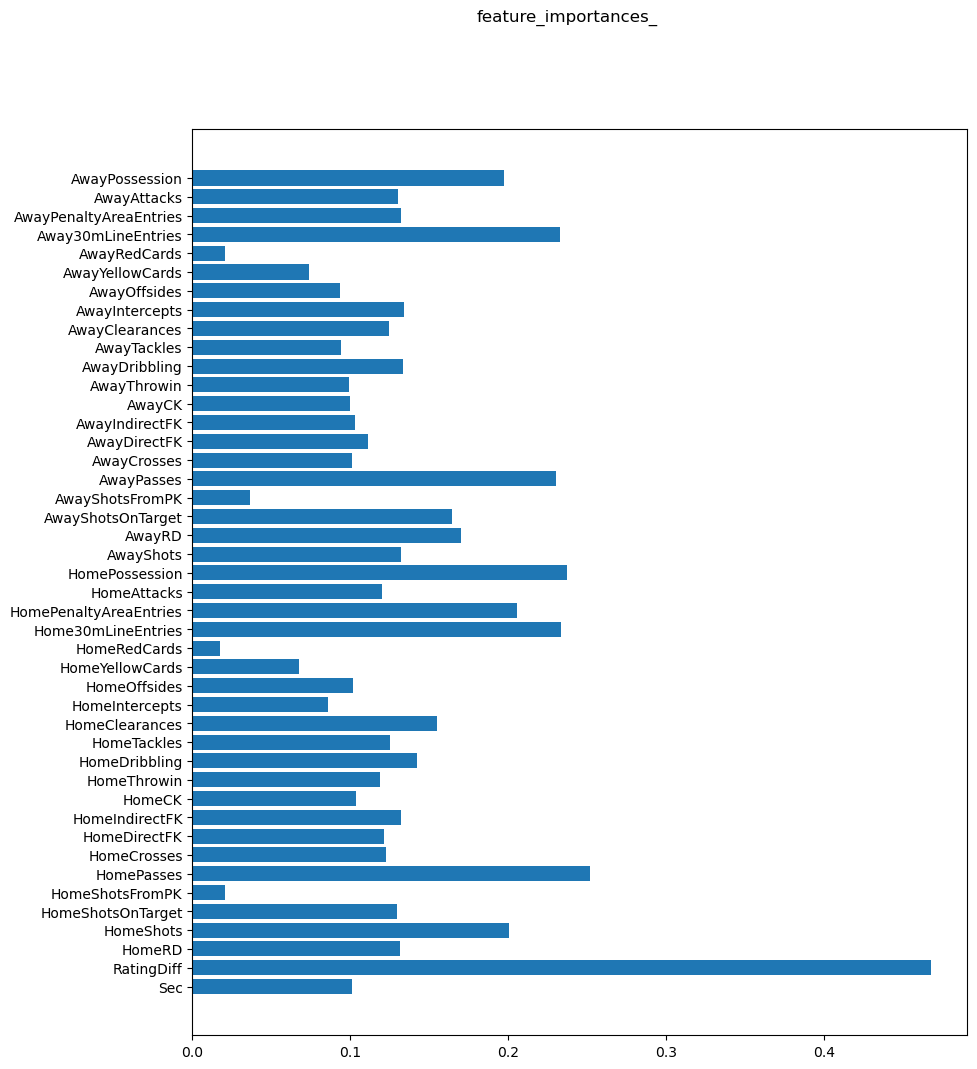

In [19]:
loglosses = []
accuracies = []
calibrations = []
feature_imp_sum = np.zeros(44)

df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)
df_allmatch.insert(14, "RatingDiff", df_allmatch["HomeRate"]-df_allmatch["AwayRate"])

df_recent_stats = pd.read_csv("./recent_stats.csv", index_col=0)
df_recent_stats.fillna({'HomeShots':10, 'HomeShotsOnTarget':3, 'HomeShotsFromPK':0.2, 'HomePasses':400,
                        'HomeCrosses':16, 'HomeDirectFK':10, 'HomeIndirectFK':2, 'HomeCK':4,
                        'HomeThrowin':20, 'HomeDribbling':10, 'HomeTackles':18, 'HomeClearances':23,
                        'HomeIntercepts':2, 'HomeOffsides':1.5, 'HomeYellowCards':1, 'HomeRedCards':0,
                        'Home30mLineEntries':33, 'HomePenaltyAreaEntries':9, 'HomeAttacks':117,
                        'HomeChanceBuildingRate':10, 'HomePossession':44,
                        'AwayShots':10, 'AwayShotsOnTarget':3, 'AwayShotsFromPK':0.2, 'AwayPasses':400,
                        'AwayCrosses':16, 'AwayDirectFK':10, 'AwayIndirectFK':2, 'AwayCK':4,
                        'AwayThrowin':20, 'AwayDribbling':10, 'AwayTackles':18, 'AwayClearances':23,
                        'AwayIntercepts':2, 'AwayOffsides':1.5, 'AwayYellowCards':1, 'AwayRedCards':0,
                        'Away30mLineEntries':33, 'AwayPenaltyAreaEntries':9, 'AwayAttacks':117,
                        'AwayChanceBuildingRate':10, 'AwayPossession':44}, inplace=True)
df_recent_stats.sort_index(inplace=True)

df = pd.concat([df_allmatch ,df_recent_stats], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df = df.reset_index().set_index("Date")
df.rename(columns={'index': 'ID'}, inplace=True)

df.sort_index(inplace=True)


for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[['Sec','RatingDiff','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession', 
             'AwayRD','AwayShots','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[['Sec','RatingDiff','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
             'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
             'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
             'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
             'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
              'HomePossession', 
             'AwayRD','AwayShots','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
             'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
             'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
             'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
             'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    feature_imp_sum = feature_imp_sum + rf.feature_importances_

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")


left = range(44)
height=feature_imp_sum

label = ['Sec','RatingDiff','HomeRD','HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
                 'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
                 'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
                 'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
                 'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
                  'HomePossession', 'AwayShots',
                 'AwayRD','AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
                 'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
                 'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
                 'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
                 'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayPossession']

plt.figure(figsize=(10, 12), dpi=100)
plt.barh(left, height,tick_label=label, align="center")
plt.suptitle("feature_importances_")
plt.show()

### 訓練データ: recent_statsの差分, Rateの差分, RDの差分

In [20]:
df_allmatch = pd.read_csv("./match_data_yearly/all_years.csv")
df_allmatch["Date"] = pd.to_datetime(df_allmatch["Date"])
df_allmatch.set_index("ID",inplace=True)
df_allmatch.sort_index(inplace=True)

df_recent_stats = pd.read_csv("./recent_stats.csv", index_col=0)
df_recent_stats.sort_index(inplace=True)

df = pd.concat([df_allmatch ,df_recent_stats], axis=1)
df.fillna({'HomeShots':10, 'HomeShotsOnTarget':3, 'HomeShotsFromPK':0.2, 'HomePasses':400,
                        'HomeCrosses':16, 'HomeDirectFK':10, 'HomeIndirectFK':2, 'HomeCK':4,
                        'HomeThrowin':20, 'HomeDribbling':10, 'HomeTackles':18, 'HomeClearances':23,
                        'HomeIntercepts':2, 'HomeOffsides':1.5, 'HomeYellowCards':1, 'HomeRedCards':0,
                        'Home30mLineEntries':33, 'HomePenaltyAreaEntries':9, 'HomeAttacks':117,
                        'HomeChanceBuildingRate':10, 'HomePossession':44,
                        'AwayShots':10, 'AwayShotsOnTarget':3, 'AwayShotsFromPK':0.2, 'AwayPasses':400,
                        'AwayCrosses':16, 'AwayDirectFK':10, 'AwayIndirectFK':2, 'AwayCK':4,
                        'AwayThrowin':20, 'AwayDribbling':10, 'AwayTackles':18, 'AwayClearances':23,
                        'AwayIntercepts':2, 'AwayOffsides':1.5, 'AwayYellowCards':1, 'AwayRedCards':0,
                        'Away30mLineEntries':33, 'AwayPenaltyAreaEntries':9, 'AwayAttacks':117,
                        'AwayChanceBuildingRate':10, 'AwayPossession':44}, inplace=True)

df = df[df['Year'] >= 2012]


df = df.reset_index().set_index("Date")
df.rename(columns={'index': 'ID'}, inplace=True)

df.sort_index(inplace=True)

items = ['Rate','RD','Shots', 'ShotsOnTarget', 'ShotsFromPK','Passes', 'Crosses', 'DirectFK', 'IndirectFK', 'CK','Throwin', 'Dribbling', 'Tackles', 'Clearances',
       'Intercepts', 'Offsides', 'YellowCards', 'RedCards','30mLineEntries', 'PenaltyAreaEntries', 'Attacks', 'Possession']

for item in items:
    df.insert(len(df.columns), f"{item}Diff", df[f"Home{item}"]-df[f"Away{item}"])

2015 的中率:0.464, 対数損失:1.053, 較正値:1.024
2016 的中率:0.503, 対数損失:1.021, 較正値:0.981
2017 的中率:0.448, 対数損失:1.053, 較正値:1.099
2018 的中率:0.425, 対数損失:1.074, 較正値:1.102
2019 的中率:0.441, 対数損失:1.064, 較正値:1.092
2020 的中率:0.484, 対数損失:1.043, 較正値:0.953
的中率(Accuracy) : 0.461
対数損失(Log loss) : 1.051
較正値(Calibration ) : 1.042


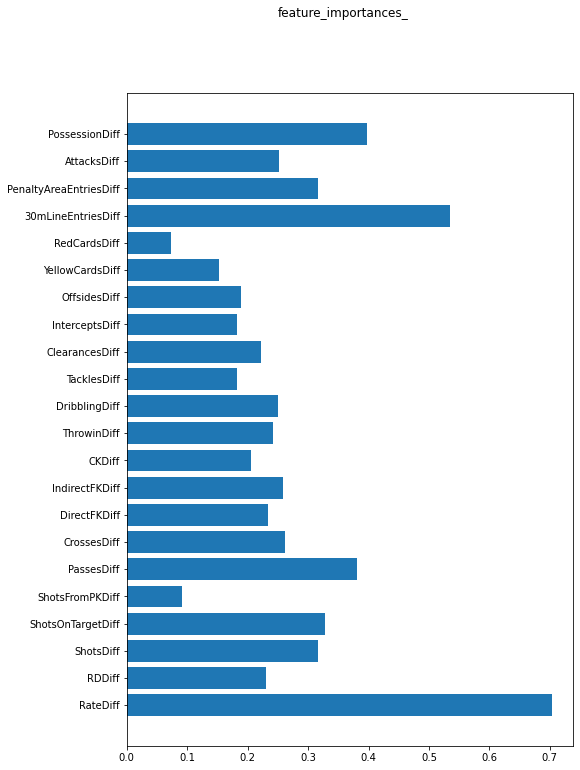

In [21]:
loglosses = []
accuracies = []
train_accuracies = []
calibrations = []
feature_imp_sum = np.zeros(22)

for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[['RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[['RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    train_accuracies.append(rf.score(X_train,y_train))
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    feature_imp_sum = feature_imp_sum + rf.feature_importances_


    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")


left = range(22)
height=feature_imp_sum

label = ['RateDiff', 'RDDiff', 'ShotsDiff',
       'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
       'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
       'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
       'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
       'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']

plt.figure(figsize=(8, 12))
plt.barh(left, height,tick_label=label, align="center")
plt.suptitle("feature_importances_")
plt.show()

### 訓練データ: recent_stats, Rate,RD,recent_statsの差, Rateの差,RDの差

2015 的中率:0.464, 対数損失:1.045, 較正値:1.003
2016 的中率:0.503, 対数損失:1.022, 較正値:0.969
2017 的中率:0.461, 対数損失:1.056, 較正値:1.052
2018 的中率:0.435, 対数損失:1.070, 較正値:1.058
2019 的中率:0.435, 対数損失:1.067, 較正値:1.087
2020 的中率:0.471, 対数損失:1.037, 較正値:0.966
的中率(Accuracy) : 0.461
対数損失(Log loss) : 1.050
較正値(Calibration ) : 1.022


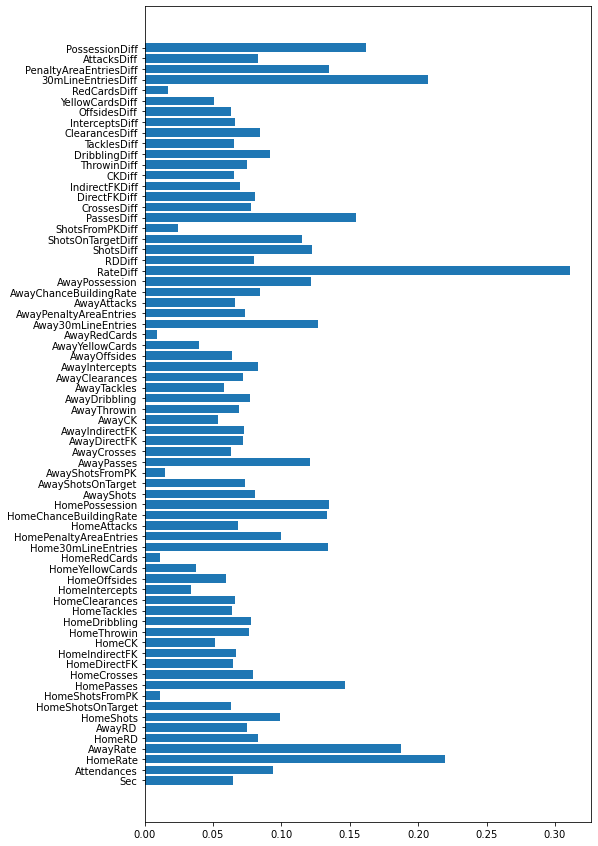

In [22]:
loglosses = []
accuracies = []
train_accuracies = []
calibrations = []
error_squares = []
losses = []
feature_imp_sum = np.zeros(70)


for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[[ 'Sec', 'Attendances', 'HomeRate', 'AwayRate',
   'HomeRD', 'AwayRD', 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
   'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
   'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
   'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
   'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
   'HomeChanceBuildingRate', 'HomePossession', 'AwayShots',
   'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
   'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
   'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
   'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
   'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayChanceBuildingRate',
   'AwayPossession','RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[[ 'Sec', 'Attendances', 'HomeRate', 'AwayRate',
   'HomeRD', 'AwayRD', 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
   'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
   'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
   'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
   'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
   'HomeChanceBuildingRate', 'HomePossession', 'AwayShots',
   'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
   'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
   'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
   'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
   'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayChanceBuildingRate',
   'AwayPossession','RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    train_accuracies.append(rf.score(X_train,y_train))
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)
    
    loss = log_loss(y_pred,y_pred_proba,labels=[0,1,2])
    losses.append(loss)
    

    feature_imp_sum = feature_imp_sum + rf.feature_importances_

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")


left = range(70)
height=feature_imp_sum

label = [ 'Sec', 'Attendances', 'HomeRate', 'AwayRate',
       'HomeRD', 'AwayRD', 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
       'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
       'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
       'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
       'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
       'HomeChanceBuildingRate', 'HomePossession', 'AwayShots',
       'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
       'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
       'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
       'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
       'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayChanceBuildingRate',
       'AwayPossession','RateDiff', 'RDDiff', 'ShotsDiff',
       'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
       'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
       'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
       'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
       'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']

plt.figure(figsize=(8, 15))
plt.barh(left, height,tick_label=label, align="center")
plt.show()

### 考察

的中率はどの訓練データを使っても､45 ~ 46%でほぼ変化なし｡
Loglossに関しては1.05ほどでどの訓練データでも差がほとんど生まれなかった.
つまり,アウトプットしている予測確率にほとんど差がない.

### ★★★予測結果をCSV,JSONで保存★★★

｢訓練データ: recent_stats, Rate,RD,recent_statsの差, Rateの差,RDの差(的中率の平均値 : 0.461)｣ のpredict_probaをCSV･JSONに保存する

In [25]:
accuracies = []
train_accuracies = []
calibrations = []
feature_imp_sum = np.zeros(70)


for year in (2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[[ 'Sec', 'Attendances', 'HomeRate', 'AwayRate',
   'HomeRD', 'AwayRD', 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
   'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
   'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
   'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
   'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
   'HomeChanceBuildingRate', 'HomePossession', 'AwayShots',
   'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
   'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
   'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
   'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
   'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayChanceBuildingRate',
   'AwayPossession','RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test=df_future[[ 'Sec', 'Attendances', 'HomeRate', 'AwayRate',
   'HomeRD', 'AwayRD', 'HomeShots', 'HomeShotsOnTarget', 'HomeShotsFromPK',
   'HomePasses', 'HomeCrosses', 'HomeDirectFK', 'HomeIndirectFK', 'HomeCK',
   'HomeThrowin', 'HomeDribbling', 'HomeTackles', 'HomeClearances',
   'HomeIntercepts', 'HomeOffsides', 'HomeYellowCards', 'HomeRedCards',
   'Home30mLineEntries', 'HomePenaltyAreaEntries', 'HomeAttacks',
   'HomeChanceBuildingRate', 'HomePossession', 'AwayShots',
   'AwayShotsOnTarget', 'AwayShotsFromPK', 'AwayPasses', 'AwayCrosses',
   'AwayDirectFK', 'AwayIndirectFK', 'AwayCK', 'AwayThrowin',
   'AwayDribbling', 'AwayTackles', 'AwayClearances', 'AwayIntercepts',
   'AwayOffsides', 'AwayYellowCards', 'AwayRedCards', 'Away30mLineEntries',
   'AwayPenaltyAreaEntries', 'AwayAttacks', 'AwayChanceBuildingRate',
   'AwayPossession','RateDiff', 'RDDiff', 'ShotsDiff',
   'ShotsOnTargetDiff', 'ShotsFromPKDiff', 'PassesDiff', 'CrossesDiff',
   'DirectFKDiff', 'IndirectFKDiff', 'CKDiff', 'ThrowinDiff',
   'DribblingDiff', 'TacklesDiff', 'ClearancesDiff', 'InterceptsDiff',
   'OffsidesDiff', 'YellowCardsDiff', 'RedCardsDiff', '30mLineEntriesDiff',
   'PenaltyAreaEntriesDiff', 'AttacksDiff', 'PossessionDiff']].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=5, random_state=1234)  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    accuracy = rf.score(X_test,y_test) 
    train_accuracies.append(rf.score(X_train,y_train))
    accuracies.append(accuracy)
    
    logloss = log_loss(y_test,y_pred_proba,labels=[0,1,2])
    loglosses.append(logloss)

    feature_imp_sum = feature_imp_sum + rf.feature_importances_


    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    for test,pred,pred_proba in zip(y_test,y_pred,y_pred_proba):
        # ホーム優位
        if pred == 1: 
            pred_winrate_sum += pred_proba[1] 
            if test == 1: 
                actual_win_sum += 1
        # アウェイ優位
        elif pred==2: 
            pred_winrate_sum += pred_proba[2] 
            if test == 2:
                actual_win_sum += 1

    calibration = pred_winrate_sum/actual_win_sum
    calibrations.append(calibration)
    
    print(f"{year} 的中率:{accuracy:.3f}, 対数損失:{logloss:.3f}, 較正値:{calibration:.3f}")
    
    ###  predict_probaをCSVとJSONに変換(誤動作防止の為, コメントアウト)
    df_y_pred_proba = pd.DataFrame(y_pred_proba)
    df_y_pred_proba.insert(0,"MatchID",df_future["ID"].values)
    df_y_pred_proba = df_y_pred_proba.set_index("MatchID")
#     df_y_pred_proba.to_csv(f"./predict_proba_random_forest/{year}.csv")
#     df_y_pred_proba.to_json(f"./predict_proba_random_forest/{year}.json", orient="index")

print("======================================")    
print(f"的中率(Accuracy) : {np.mean(accuracies):.3f}" )
print(f"対数損失(Log loss) : {np.mean(loglosses):.3f}" )
print(f"較正値(Calibration ) : {np.mean(calibrations):.3f}")


2015 的中率:0.464, 対数損失:1.045, 較正値:1.003
2016 的中率:0.503, 対数損失:1.022, 較正値:0.969
2017 的中率:0.461, 対数損失:1.056, 較正値:1.052
2018 的中率:0.435, 対数損失:1.070, 較正値:1.058
2019 的中率:0.435, 対数損失:1.067, 較正値:1.087
2020 的中率:0.471, 対数損失:1.037, 較正値:0.966
的中率(Accuracy) : 0.461
対数損失(Log loss) : 1.050
較正値(Calibration ) : 1.022
